In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim

# More on model fitting using PyTorch

## Piecewise Linear Model via Pytorch: importance of scaling

The following dataset is from \url{https://fred.stlouisfed.org/series/TLCOMCONS}. It is slightly different from the dataset used in Lecture 24 (which was \url{https://fred.stlouisfed.org/series/TTLCONS}).  

  observation_date  TLCOMCONS
0       2002-01-01      68254
1       2002-02-01      65840
2       2002-03-01      66722
3       2002-04-01      64879
4       2002-05-01      62741
5       2002-06-01      60982
6       2002-07-01      58971
7       2002-08-01      61223
8       2002-09-01      61997
9       2002-10-01      61772
    observation_date  TLCOMCONS
268       2024-05-01     126084
269       2024-06-01     125371
270       2024-07-01     124989
271       2024-08-01     125184
272       2024-09-01     125608
273       2024-10-01     124379
274       2024-11-01     125270
275       2024-12-01     125645
276       2025-01-01     124650
277       2025-02-01     125988


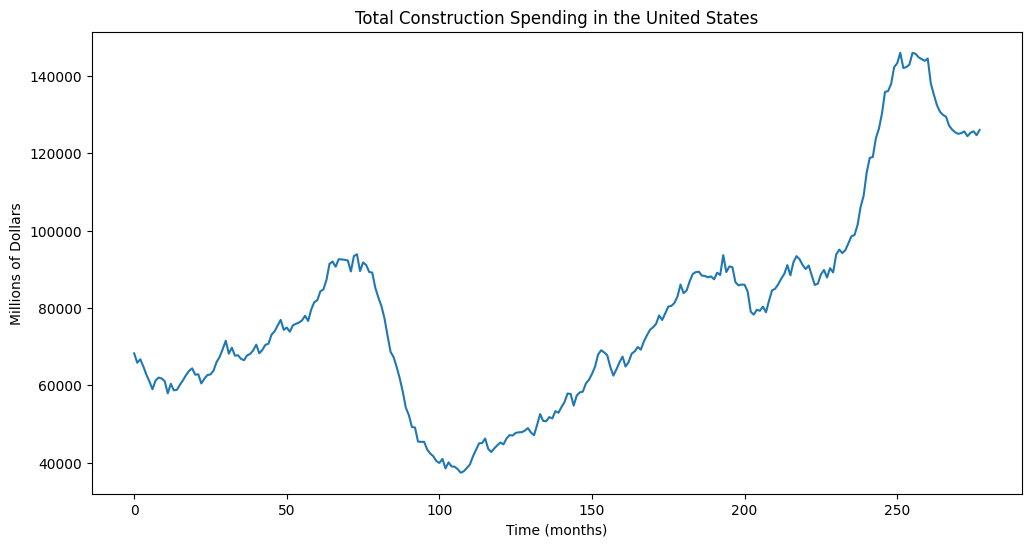

In [2]:
ttlcons = pd.read_csv('TLCOMCONS_23April2025.csv')
print(ttlcons.head(10))
print(ttlcons.tail(10))

y_raw = ttlcons['TLCOMCONS']
n = len(y_raw)
x_raw = np.arange(1, n+1)

plt.figure(figsize = (12, 6))
plt.plot(y_raw)
plt.xlabel("Time (months)")
plt.ylabel('Millions of Dollars')
plt.title("Total Construction Spending in the United States")
plt.show()

Let us try to fit the model: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 t + \beta_2 (x_t - c_1)_+ + \beta_3 (x_t - c_2)_+ + \dots + \beta_{k+1} (x_t - c_k)_+ + \epsilon_t
\end{equation*}
where the unknown parameters are $\beta_0,\beta_1, \dots, \beta_{k+1}$ and $c_1, \dots, c_k$ (as well as $\sigma$ which is the noise level in $\epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$). We will fix a value of $k$. Here $x_t = t$. In Lecture 24, we fit this model after taking logarithms; here let us work with the original data to see the importance of scaling variables. 

In PyTorch, this model can be coded as follows. 

In [3]:
class PiecewiseLinearModel(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32)) 
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype=torch.float32))
        # When a tensor is wrapped in nn.Parameter and assigned as an attribute to a nn.Module, 
        # it is automatically registered as a parameter of that module.

    def forward(self, x):
        knots_sorted, _ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out += self.beta[j + 2] * torch.relu(x - knots_sorted[j])
        return out

The parameters will be estimated simply by least squares, i.e., by minimizing
\begin{equation*}
  \sum_{t=1}^n \left(y_t - \beta_0 - \beta_1 t - \beta_2 (x_t - c_1)_+ - \dots - \beta_{k+1} (x_t - c_k)_+ \right)^2 
\end{equation*}
This is possibly a non-convex minimization problem (note that we are optimizing over $c_1, \dots, c_k$ as well). The algorithm used will be gradient descent (or a variant such as Adam). Initialization will be important for the algorithm to work well and not get stuck in bad local minima. 

Here is how the least squares minimization is solved in PyTorch. The first step is to convert the data y_raw and x_raw into PyTorch tensors. 

In [4]:
y_raw_torch = torch.tensor(y_raw, dtype = torch.float32).unsqueeze(1)
x_raw_torch = torch.tensor(x_raw, dtype = torch.float32).unsqueeze(1)

print(y_raw_torch.shape)
print(x_raw_torch.shape)

torch.Size([278, 1])
torch.Size([278, 1])


The next step is to create suitable initialization. It is natural to take $c_1, \dots, c_k$ to be quantiles of $x_t$ at $1/(k+1), \dots, k/(k+1)$. For $\beta_0, \dots, \beta_{k+2}$, we run a linear regression with these initial $c_1, \dots, c_k$ and then take the corresponding coefficients.  

In [5]:
# First fix the number of knots
k = 4

quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_raw, quantile_levels)

n = len(y_raw)
X = np.column_stack([np.ones(n), x_raw])
for j in range(k):
    xc = ((x_raw > knots_init[j]).astype(float)) * (x_raw - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_raw, X).fit()
beta_init = md_init.params.values

print(knots_init)
print(beta_init)

[ 56.4 111.8 167.2 222.6]
[52167.91700846   628.19139706 -1505.22955093  1506.51113458
  -264.69041849   565.3087544 ]


Once the initial values are determined, we construct our model. 

In [6]:
# Define a model
md_nn = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
# This code creates an instance of our custom neural network class
# It also initializes the knots at knots_init

Now we shall run the optimization algorithm which starts with these initial estimates, and then iteratively updates them. The crucial hyperparameter  in the optimization algorithm is the learning rate (denoted by lr in the code below). This controls how much to adjust the parameters with respect to the gradient during each step of optimization. A smaller value means smaller steps, which can lead to more stable convergence but possibly slower training. A larger learning rate would update the parameters more aggressively, which might speed up training but risks overshooting the minimum.   

In [7]:
# Define an optimizer
optimizer = optim.Adam(md_nn.parameters(), lr = 1.0)
# https://docs.pytorch.org/docs/stable/optim.html
# try lr = 0.01, 0.1 and 1

# Define a loss function
loss_fn = nn.MSELoss()
loss_values = []

for epoch in range(300000): 
    # Zero out gradients
    optimizer.zero_grad()
    # Without zeroing the gradients before each iteration, 
    # gradients from previous iterations would accumulate, 
    # leading to incorrect updates of the model's parameters.

    # Compute loss
    y_pred = md_nn(x_raw_torch)
    loss = loss_fn(y_pred, y_raw_torch)

    # Compute gradients
    loss.backward()
    # The .backward() method calculates the gradients of that tensor 
    # with respect to all the parameters in the network that contributed to its computation.  

    # Update parameters
    optimizer.step()
    # The .step() method performs a single optimization step, 
    # updating the model's parameters based on the gradients computed during the backward pass.

    loss_values.append(loss.item())
    if epoch % 1000 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 80948888.0000
Epoch 1000, Loss: 52399508.0000
Epoch 2000, Loss: 49242824.0000
Epoch 3000, Loss: 47964040.0000
Epoch 4000, Loss: 47336768.0000
Epoch 5000, Loss: 46942112.0000
Epoch 6000, Loss: 46699364.0000
Epoch 7000, Loss: 46517784.0000
Epoch 8000, Loss: 46565056.0000
Epoch 9000, Loss: 46373556.0000
Epoch 10000, Loss: 46316752.0000
Epoch 11000, Loss: 46285712.0000
Epoch 12000, Loss: 46241228.0000
Epoch 13000, Loss: 46203376.0000
Epoch 14000, Loss: 46175032.0000
Epoch 15000, Loss: 46153744.0000
Epoch 16000, Loss: 46137504.0000
Epoch 17000, Loss: 46124436.0000
Epoch 18000, Loss: 46136976.0000
Epoch 19000, Loss: 46105196.0000
Epoch 20000, Loss: 46374868.0000
Epoch 21000, Loss: 46591068.0000
Epoch 22000, Loss: 46439060.0000
Epoch 23000, Loss: 46085180.0000
Epoch 24000, Loss: 46090524.0000
Epoch 25000, Loss: 46396488.0000
Epoch 26000, Loss: 46078640.0000
Epoch 27000, Loss: 46105336.0000
Epoch 28000, Loss: 46142696.0000
Epoch 29000, Loss: 46072500.0000
Epoch 30000, Loss: 4609

Here are some points that can be verified: 
1. When the learning rate is 0.01, the algorithm is moving too slowly and we get convergence after about 300000 epochs (the smallest loss is around 46047484). 
2. When the learning rate is 0.1, the algorithm is still slow and convergence seems to be achieved at around 150000 epochs. 
3. When the learning rate is 1, the algorithm does not seem to settle down, and is oscillating quite a bit even after reaching around the smallest loss. 

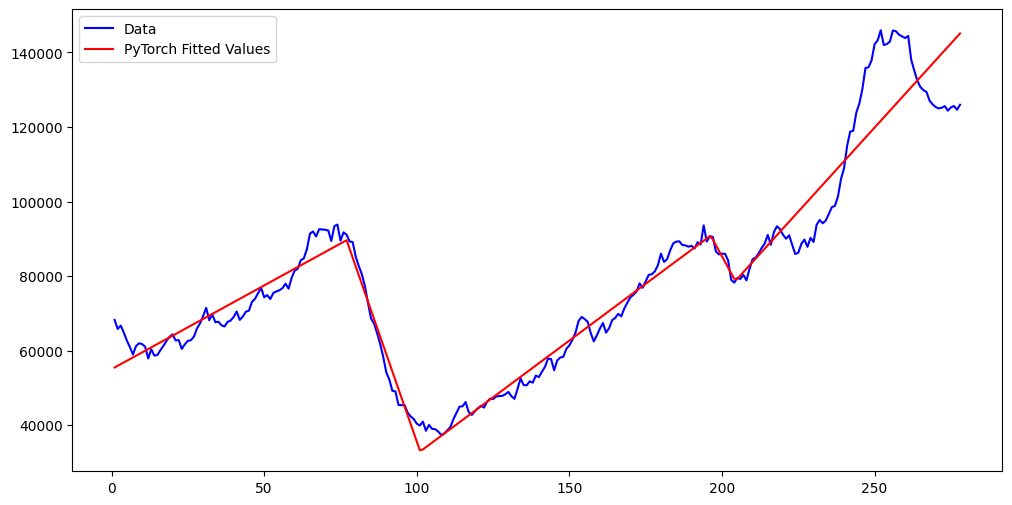

In [8]:
nn_fits_1 = md_nn(x_raw_torch).detach().numpy()
# detach() in PyTorch creates a new tensor that shares the same storage as the original tensor 
# but is detached from the computation graph.

plt.figure(figsize = (12, 6))
plt.plot(x_raw, y_raw, color = 'blue', label = 'Data')
plt.plot(x_raw, nn_fits_1, color = 'red', label = 'PyTorch Fitted Values')
plt.legend()
plt.show()

Now we shall scale the covariates $x_t$ and $y_t$, and then run the same algorithm again.

In [9]:
y_scaled = (y_raw - np.mean(y_raw)) / (np.std(y_raw))
x_scaled = (x_raw - np.mean(x_raw)) / (np.std(x_raw))

y_torch = torch.tensor(y_scaled, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_scaled, dtype = torch.float32).unsqueeze(1)

In [10]:
# First fix the number of knots
k = 4

quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack([np.ones(n), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float)) * (x_scaled - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_scaled, X).fit()

beta_init = md_init.params.values

print(knots_init)
print(beta_init)

[-1.03549894 -0.34516631  0.34516631  1.03549894]
[ 2.26579783  1.87350378 -4.48916248  4.49298465 -0.7894067   1.68596401]


Now the $\beta$ coefficients are of the same scale. 

In [11]:
md_nn = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)

In [12]:
optimizer = optim.Adam(md_nn.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()

for epoch in range(20000):
    # Zero out gradients
    optimizer.zero_grad()

    # Compute loss
    y_pred = md_nn(x_torch)
    loss = loss_fn(y_pred, y_torch)

    # Compute gradient
    loss.backward()

    # Update parameters
    optimizer.step()

    if epoch % 1000 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.1118
Epoch 1000, Loss: 0.0671
Epoch 2000, Loss: 0.0653
Epoch 3000, Loss: 0.0641
Epoch 4000, Loss: 0.0639
Epoch 5000, Loss: 0.0637
Epoch 6000, Loss: 0.0637
Epoch 7000, Loss: 0.0637
Epoch 8000, Loss: 0.0637
Epoch 9000, Loss: 0.0637
Epoch 10000, Loss: 0.0636
Epoch 11000, Loss: 0.0636
Epoch 12000, Loss: 0.0637
Epoch 13000, Loss: 0.0637
Epoch 14000, Loss: 0.0636
Epoch 15000, Loss: 0.0636
Epoch 16000, Loss: 0.0637
Epoch 17000, Loss: 0.0637
Epoch 18000, Loss: 0.0637
Epoch 19000, Loss: 0.0636


Now the convergence is much faster (after about 8000 iterations). Let us plot the fitted values on the original scale. 

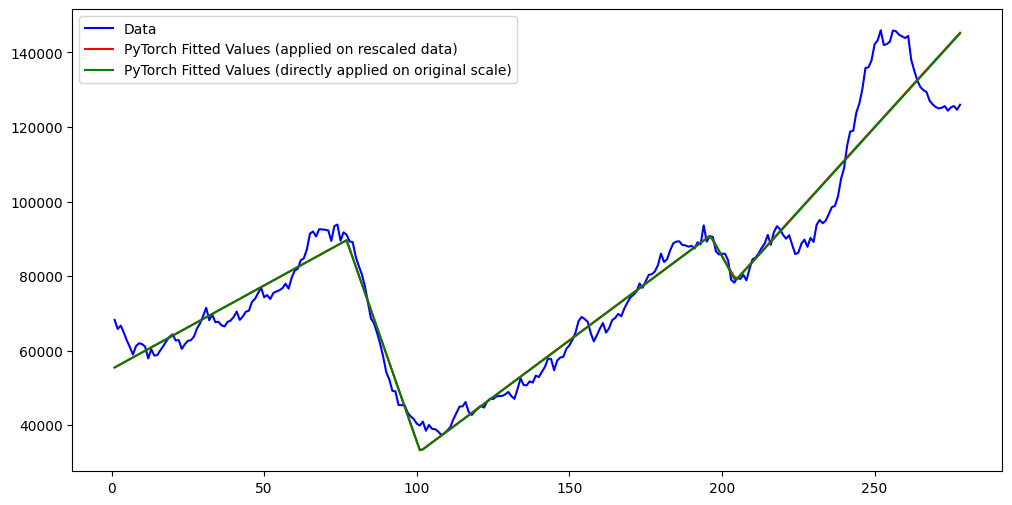

In [13]:
nn_fits_2 = md_nn(x_torch).detach().numpy()
nn_fits_original_scale_2 = (nn_fits_2 * np.std(y_raw)) + np.mean(y_raw)

plt.figure(figsize = (12, 6))
plt.plot(x_raw, y_raw, color = 'blue', label = 'Data')
plt.plot(x_raw, nn_fits_original_scale_2, color = 'red', label = 'PyTorch Fitted Values (applied on rescaled data)')
plt.plot(x_raw, nn_fits_1, color = 'green', label = 'PyTorch Fitted Values (directly applied on original scale)')
plt.legend()
plt.show()

The fit is the same as what we got by running the code on the original raw data. But the convergence of the algorithm is much faster with scaling. This is why scaling is almost always recommended.

## More Model Fitting using PyTorch

In Lecture 24, we showed how PyTorch can be used for parameter estimation in the following models: 
1. $y_t = \beta_0 + \beta_1 x_t + \beta_2 (x_t - c_1)_+ + \dots + \beta_{k+1} (x_t - c_k)_+ + \epsilon_t$
2. $y_t = \mu + \epsilon_t + \theta \epsilon_{t-1}$ (with $\epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$) 
3. $y_t = \phi_0 + \phi_1 y_{t-1} + \epsilon_t$ (with $\epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$)

Today we shall discuss the variance model, and spectrum model (from Lectures 14-15) and use PyTorch to fit the parameters. 

### Variance Model

The variance model is simply $y_t \overset{\text{ind}}{\sim} N(0, \tau_t^2)$. We have seen from Lecture 14 that the negative log-likelihood is: 
\begin{align*}
   \sum_{t=1}^n \left(\log \tau_t + \frac{y_t^2}{2 \tau^2_t} \right). 
\end{align*}
We reparametrize and write the objective function in terms of $\alpha_t = \log \tau_t$ to get: 
\begin{align*}
  \sum_{t=1}^n \left(\alpha_t + \frac{y_t^2}{2} e^{-2 \alpha_t} \right). 
\end{align*}
We also saw in Lecture 14 that unconstrained minimization of this negative log-likelihood with respect to $\alpha_t$ gives $\alpha_t = \log |y_t|$, which is complete overfitting in this model.  To prevent overfitting, we can consider the following model for $\alpha_t$: 
\begin{align*}
   \alpha_t = \beta_0 + \beta_1 t + \beta_2 (t - c_1)_+ + \dots + \beta_{k+1} (t - c_k)_+. 
\end{align*}
If $k$ is small, then overfitting is prevented, and we would get useful estimates. The optimization problem now is to minimize the above negative log-likelihood when $\alpha_t$ is of the above form. When $k$ is small, we will not change the objective function by including a regularization penalty. 

First let us create a simulation setting for fitting this model. We shall use one of the simulation settings from Lecture 14. 

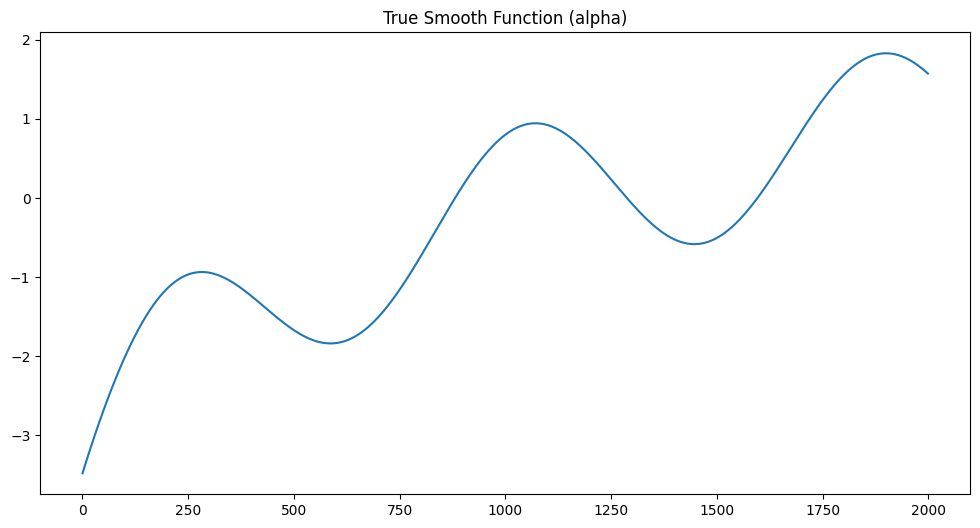

In [14]:
# the following is the true alpha_t function:
def smoothfun(x):
    ans = np.sin(15 * x) + np.exp(-(x ** 2)/2) + 0.5 * ((x - 0.5) ** 2) + 2 * np.log(x + 0.1)
    return ans

n = 2000
xx = np.linspace(0, 1, n)
alpha_true = np.array([smoothfun(x) for x in xx])

plt.figure(figsize = (12, 6))
plt.plot(alpha_true)
plt.title('True Smooth Function (alpha)')
plt.show()

We generate data from the above true function using the model: $y_t \overset{\text{ind}}{\sim} N(0, \tau_t^2)$ where $\tau_t = \exp(\alpha_t)$. 

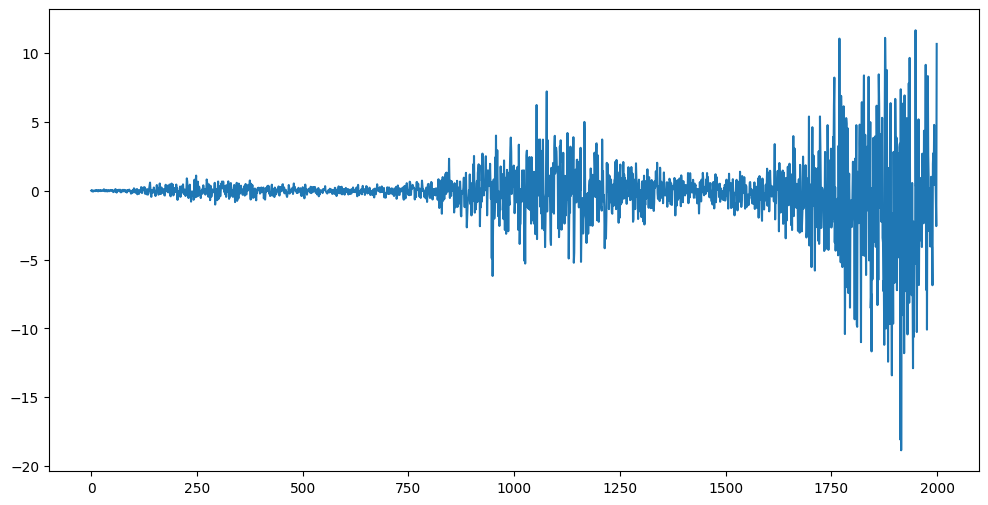

In [15]:
# Generating Data using the above smooth function: 
tau_t = np.exp(alpha_true)
rng = np.random.default_rng(seed = 42)
y = rng.normal(loc = 0, scale = tau_t)

plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

The goal is to get back the estimates of $\alpha_t$ from the above data. 

We rescale $x$ below (but not $y$). Note that this model is not invariant to rescaling both $y$ and $x$. 

In [16]:
# we rescale x but not y
x_raw = np.arange(1, n+1)
x_scaled = (x_raw - np.mean(x_raw))/(np.std(x_raw))
y_torch = torch.tensor(y, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_scaled, dtype = torch.float32).unsqueeze(1)

We now select the initial values. We take $c_1, \dots, c_k$ to be quantiles of $x_t$ at $1/(k+1), \dots, k/(k+1)$. For $\beta_0, \dots, \beta_{k+2}$, we run a linear regression of $\log y_t$ on $1, x_t, (x_t - c_1)_+, \dots, (x_t - c_k)_+$ with these initial $c_1, \dots, c_k$ and then take the corresponding coefficients.  

In [17]:
k = 8 # this is the number of knots
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y)
X = np.column_stack([np.ones(n), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float)) * (x_scaled - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(np.log(np.abs(y)), X).fit()

#print(md_init.summary())
#print(md_init.params)
beta_init = md_init.params
print(knots_init)
print(beta_init)

[-1.34647722 -0.96176944 -0.57706167 -0.19235389  0.19235389  0.57706167
  0.96176944  1.34647722]
[ 7.44006624  6.59898963 -8.17888252  0.61656712  5.50695701 -1.94742617
 -5.67882692  2.43967538  5.87140635 -4.41572431]


We now use PyTorch to estimate $\alpha_t$. The first step is to create the model. We use the same piecewise linear model that we used in Lecture 24.  

In [18]:
class PiecewiseLinearModel(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype = torch.float32)) 
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype = torch.float32))

    def forward(self, x):
        knots_sorted, _ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out += self.beta[j + 2] * torch.relu(x - knots_sorted[j])
        return out

The following code creates this model. 

In [19]:
md_PiecewiseLinear = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
# This code creates an instance of our custom neural network class
# It also initializes the knots at knots_init

The following code runs the optimizer. The only thing that is different from the piecewise linear regression model is the loss function. 

In [20]:
optimizer = optim.Adam(md_PiecewiseLinear.parameters(), lr = 0.01) 
# the above line tells Python to create an Adam optimizer that will update all parameters 
# of md_PiecewiseLinear during training, using a learning rate of 0.01. 

for epoch in range(20000): 
    optimizer.zero_grad()

    y_pred = md_PiecewiseLinear(x_torch)
    #loss = loss_fn(y_pred, y_torch)
    loss = torch.sum( y_pred + (y_torch**2) / 2 * torch.exp(-2 * y_pred) )

    loss.backward() # calulates gradients

    optimizer.step() # updates parameters using gradients

    if epoch % 1000 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
# Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 1876.1447
Epoch 1000, Loss: 384.1796
Epoch 2000, Loss: 382.5848
Epoch 3000, Loss: 380.2390
Epoch 4000, Loss: 378.5027
Epoch 5000, Loss: 376.6567
Epoch 6000, Loss: 374.1023
Epoch 7000, Loss: 373.7757
Epoch 8000, Loss: 373.1777
Epoch 9000, Loss: 372.4913
Epoch 10000, Loss: 372.2776
Epoch 11000, Loss: 372.0750
Epoch 12000, Loss: 372.0114
Epoch 13000, Loss: 372.4420
Epoch 14000, Loss: 371.9330
Epoch 15000, Loss: 371.8340
Epoch 16000, Loss: 371.8694
Epoch 17000, Loss: 371.8499
Epoch 18000, Loss: 372.0723
Epoch 19000, Loss: 371.8283


The estimate of $\alpha_t$ is obtained as follows. 

In [21]:
alpha_est = md_PiecewiseLinear(x_torch).detach().numpy()

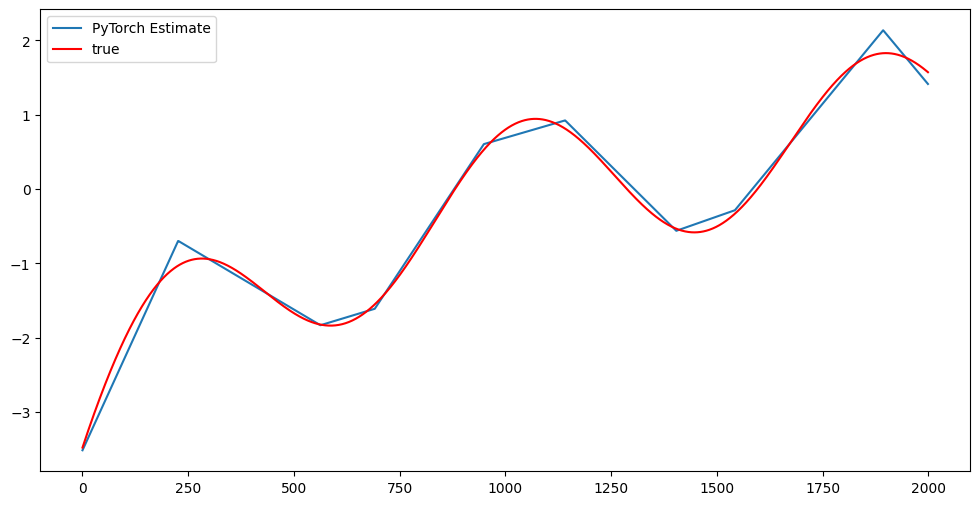

In [22]:
plt.figure(figsize = (12, 6))
plt.plot(alpha_est, label = 'PyTorch Estimate')
plt.plot(alpha_true, color = 'red', label = 'true') 
plt.legend()
plt.show()

The estimate is pretty good. 

### Spectrum Model

We have a time series $y_t$ with periodogram $I(j/n)$. The spectrum model is given by: 
\begin{equation*}
   I(j/n) \overset{\text{ind}}{\sim} f(j/n) \eta_j
\end{equation*}
for $j = 1, \dots, m$ where $m$ is the largest integer strictly smaller than $n/2$. Here $\eta_j \overset{\text{i.i.d}}{\sim} Exp(1)$. The parameters in this model are $f(j/n), j = 1, \dots, m$ (it is called the power of frequency $j/n$). 

The likelihood is given by: 
\begin{align*}
   \prod_{j=1}^m \frac{1}{f(j/n)} \exp \left(-\frac{I(j/n)}{f(j/n)} \right). 
\end{align*}
So the negative log-likelihood is: 
\begin{align*}
   \sum_{j = 1}^{m} \left(\frac{I(j/n)}{f(j/n)} + \log f(j/n)\right). 
\end{align*}
We reparametrize this by $\log f(j/n) = \alpha_j$ so the minimization problem becomes: 
\begin{align*}
   \sum_{j = 1}^{m} \left(I(j/n) \exp(-\alpha_j) + \alpha_j\right). 
\end{align*}
Unconstrained minimization is easily seen to lead to $\alpha_j = \log I(j/n)$, so it makes sense to make further constraining assumptions on $\alpha_j$. We use the assumption: 
\begin{align*}
   \alpha_j = \beta_0 + \beta_1 j + \beta_2 (j - c_1)_+ + \dots + \beta_{k+1} (j - c_k)_+. 
\end{align*}

### Example One: Sunspots Data

Let us apply the method to the sunspots dataset. 

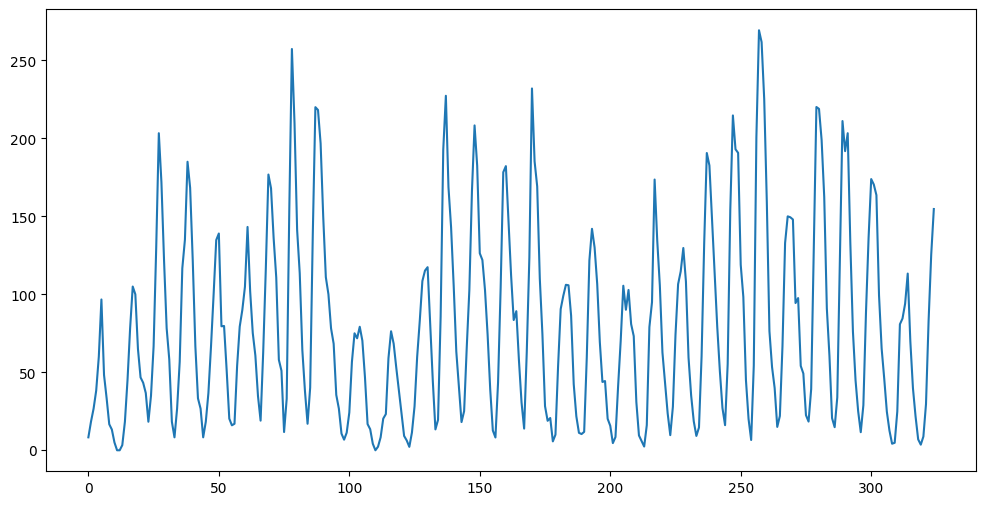

In [23]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
n = len(y)

plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

Below we compute the periodogram of the data. 

In [24]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y

In [25]:
n = len(y)
freqs, pgram = periodogram(y)
m = len(pgram)

Below we plot the periodogram and its logarithm. 

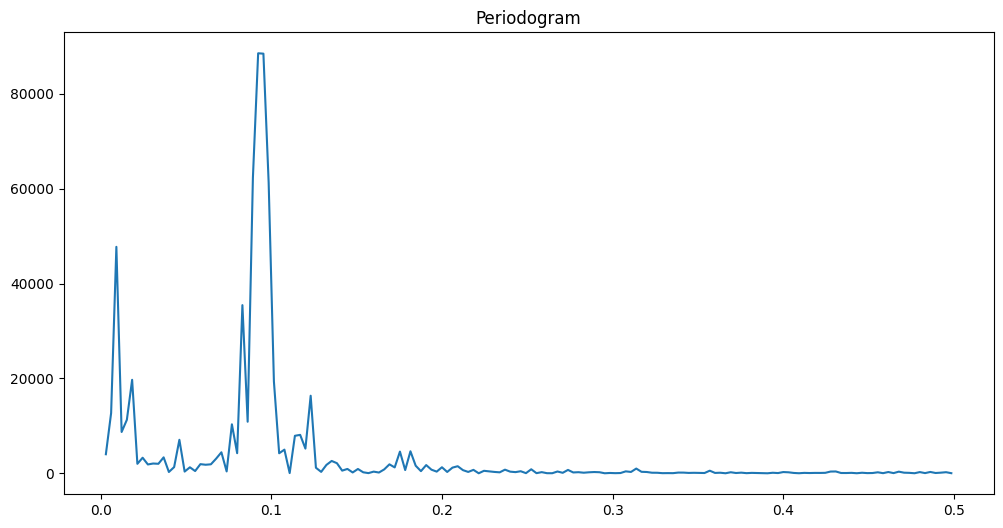

In [26]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, pgram, label = 'Periodogram')
plt.title('Periodogram')
plt.show()

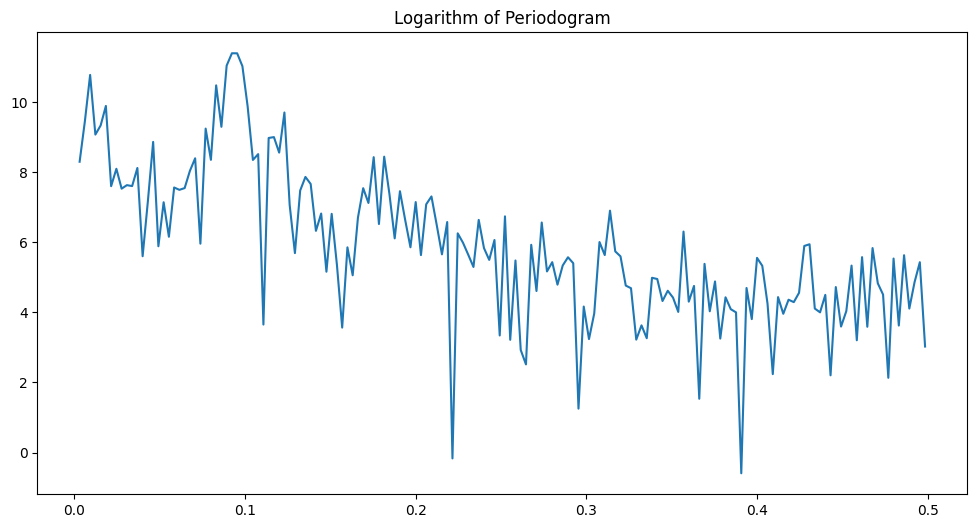

In [27]:
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram), label = 'Log Periodogram')
plt.title('Logarithm of Periodogram')
plt.show()

Our first step is to get preliminary estimates of $c_1, \dots, c_k$ and $\beta_0, \dots, \beta_{k+1}$. We rescale $j = 1, \dots, n$ to $x_1, \dots, x_m$. Then we take $c_1, \dots, c_k$ to be the quantiles of $x_j$ at $1/(k+1), \dots, k/(k+1)$. For $\beta_0, \dots, \beta_{k+2}$, we run a linear regression of $\log I(j/n)$ on $1, x_j, (x_j - c_1)_+, \dots, (x_j - c_k)_+$ with these initial $c_1, \dots, c_k$ and then take the corresponding coefficients.  

In [28]:
k = 10 # this is the number of knots
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
x = np.arange(1, m+1)
x_scaled = (x - np.mean(x))/(np.std(x))
knots_init = np.quantile(x_scaled, quantile_levels)

X = np.column_stack([np.ones(m), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float)) * (x_scaled - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(np.log(pgram), X).fit()

#print(md_init.summary())
#print(md_init.params)
beta_init = md_init.params
print(knots_init)
print(beta_init)

[-1.40841158 -1.09543123 -0.78245088 -0.46947053 -0.15649018  0.15649018
  0.46947053  0.78245088  1.09543123  1.40841158]
[ -9.0879961  -10.99249551  23.75611862 -26.47556894  16.98756723
  -9.10663734   3.89842712   2.67957451  -3.61744261   3.02132995
   0.94878987  -1.06944189]


Below we create the torch objects for use in the PyTorch code. 

In [29]:
#y_torch = torch.tensor(pgram/np.std(pgram), dtype = torch.float32).unsqueeze(1)
y_torch = torch.tensor(pgram, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_scaled, dtype = torch.float32).unsqueeze(1)

In [30]:
md_PiecewiseLinear = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
optimizer = optim.Adam(md_PiecewiseLinear.parameters(), lr = 0.01) 

for epoch in range(20000): 
    optimizer.zero_grad()

    y_pred = md_PiecewiseLinear(x_torch)
    #loss = loss_fn(y_pred, y_torch)
    loss = torch.sum( y_pred + y_torch * torch.exp(- y_pred) )

    loss.backward() # calulates gradients

    optimizer.step() # updates parameters using gradients

    if epoch % 1000 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 1230.7987
Epoch 1000, Loss: 1200.7444
Epoch 2000, Loss: 1199.7701
Epoch 3000, Loss: 1199.2241
Epoch 4000, Loss: 1198.9481
Epoch 5000, Loss: 1198.8514
Epoch 6000, Loss: 1198.7220
Epoch 7000, Loss: 1198.5948
Epoch 8000, Loss: 1198.5424
Epoch 9000, Loss: 1198.5123
Epoch 10000, Loss: 1198.4650
Epoch 11000, Loss: 1198.2202
Epoch 12000, Loss: 1198.0922
Epoch 13000, Loss: 1198.0574
Epoch 14000, Loss: 1197.9463
Epoch 15000, Loss: 1197.9348
Epoch 16000, Loss: 1197.8220
Epoch 17000, Loss: 1197.7927
Epoch 18000, Loss: 1197.7850
Epoch 19000, Loss: 1197.7164


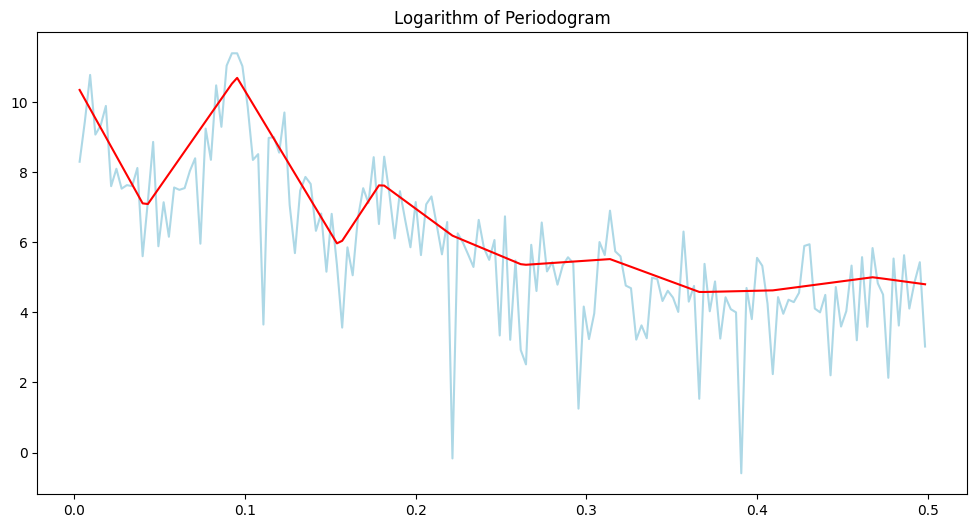

In [31]:
#alpha_est = md_PiecewiseLinear(x_torch).detach().numpy() + np.log(np.std(pgram))
alpha_est = md_PiecewiseLinear(x_torch).detach().numpy()
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram), label = 'Log Periodogram', color = 'lightblue')
plt.plot(freqs, alpha_est, color = 'red', label = 'PyTorch Estimate')
plt.title('Logarithm of Periodogram')
plt.show()

Let us compare this estimate with our previous method (from Lectures 14-15). 

In [32]:
import cvxpy as cp
#import mosek

def spectrum_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) 
    alpha = cp.Variable(m)

    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)

    problem = cp.Problem(objective)
    problem.solve()
    #problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

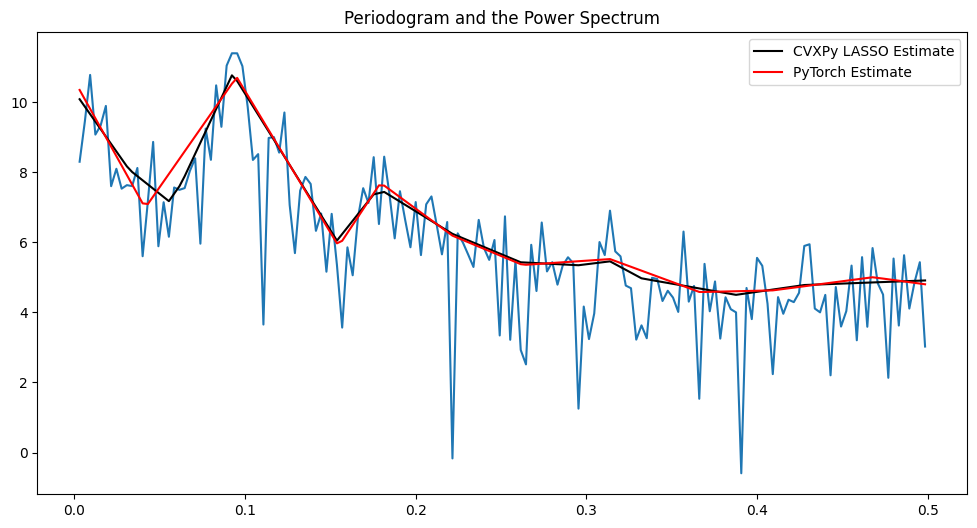

In [33]:
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 10)
power_lasso = (2/n)*(np.exp(2*alpha_opt_lasso))

plt.figure(figsize = (12, 6))
plt.plot(freq, np.log(pgram))
plt.title('Periodogram and the Power Spectrum')
plt.plot(freq, np.log(power_lasso), color = 'black', label = "CVXPy LASSO Estimate")
plt.plot(freqs, alpha_est, color = 'red', label = 'PyTorch Estimate')
plt.legend()
plt.show()


The estimates are clearly reasonably close to each other. 

### Example 2: Earthquake Data

Below is an example where this PyTorch method does not quite seem to work. This is for the earthquake dataset that we previously used in Lecture 15. 
This dataset is from the Mathworks (MATLAB) tutorial "Practical Introduction to Frequency-Domain Analysis" (see [this link](https://www.mathworks.com/help/signal/ug/practical-introduction-to-frequency-domain-analysis.html)). From this matlab tutorial: *Active Mass Driver (AMD) control systems are used to reduce vibration in a building under an earthquake. An active mass driver is placed on the top floor of the building and, based on displacement and acceleration measurements of the building floors, a control system sends signals to the driver so that the mass moves to attenuate ground disturbances. Acceleration measurements were recorded on the first floor of a three story test structure under earthquake conditions. Measurements were taken without the active mass driver control system (open loop condition), and with the active control system (closed loop condition).*

We will use the data on the open loop condition. 

dict_keys(['__header__', '__version__', '__globals__', 'gfloor1OL', 'gfloor1CL'])
(10000, 1)


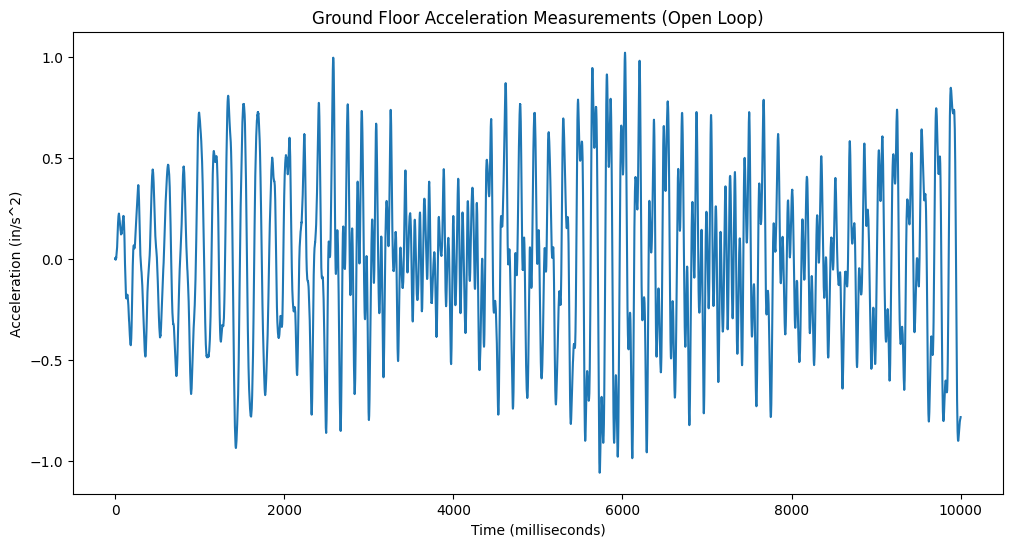

In [34]:
from scipy.io import loadmat
mat_dict = loadmat('quakevibration.mat')
print(mat_dict.keys())

gfloor1OL_array = mat_dict['gfloor1OL']
print(gfloor1OL_array.shape)

y = gfloor1OL_array.ravel()

plt.figure(figsize = (12, 6))
plt.plot(y)
plt.title('Ground Floor Acceleration Measurements (Open Loop)')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Acceleration (in/s^2)')
plt.show()

The periodogram is given by: 

In [35]:
n = len(y)
freqs, pgram = periodogram(y)
m = len(pgram)

The initial values of the parameters are obtained below. 

In [36]:
k = 10 # this is the number of knots
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
x = np.arange(1, m+1)
x_scaled = (x - np.mean(x))/(np.std(x))
knots_init = np.quantile(x_scaled, quantile_levels)

X = np.column_stack([np.ones(m), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float)) * (x_scaled - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(np.log(pgram), X).fit()

#print(md_init.summary())
#print(md_init.params)
beta_init = md_init.params
print(knots_init)
print(beta_init)

[-1.41684902 -1.10199369 -0.78713835 -0.47228301 -0.15742767  0.15742767
  0.47228301  0.78713835  1.10199369  1.41684902]
[-40.11567801 -22.89394746  20.3600293   -0.40359563   1.59487819
  -0.05497328   0.36121425   0.53068634  -0.05943841   0.45359363
  -0.23388732   0.40076595]


Here is the PyTorch code. 

In [37]:
#y_torch = torch.tensor(pgram/np.std(pgram), dtype = torch.float32).unsqueeze(1)
y_torch = torch.tensor(pgram, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_scaled, dtype = torch.float32).unsqueeze(1)

In [38]:
md_PiecewiseLinear = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
optimizer = optim.Adam(md_PiecewiseLinear.parameters(), lr = 0.01) 

for epoch in range(20000): 
    optimizer.zero_grad()

    y_pred = md_PiecewiseLinear(x_torch)
    #loss = loss_fn(y_pred, y_torch)
    loss = torch.sum( y_pred + y_torch * torch.exp(- y_pred) )

    loss.backward() # calulates gradients

    optimizer.step() # updates parameters using gradients

    if epoch % 1000 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
# Run this code a few times to be sure of convergence. 

Epoch 0, Loss: -35967.2383
Epoch 1000, Loss: -41305.5781
Epoch 2000, Loss: -41314.9375
Epoch 3000, Loss: -41330.3047
Epoch 4000, Loss: -41352.2773
Epoch 5000, Loss: -41381.5039
Epoch 6000, Loss: -41415.5938
Epoch 7000, Loss: -41448.9766
Epoch 8000, Loss: -41475.8164
Epoch 9000, Loss: -41494.0078
Epoch 10000, Loss: -41500.9023
Epoch 11000, Loss: -41510.1602
Epoch 12000, Loss: -41519.8242
Epoch 13000, Loss: -41525.5430
Epoch 14000, Loss: -41531.9727
Epoch 15000, Loss: -41537.0273
Epoch 16000, Loss: -41540.6719
Epoch 17000, Loss: -41543.7500
Epoch 18000, Loss: -41545.9062
Epoch 19000, Loss: -41547.5859


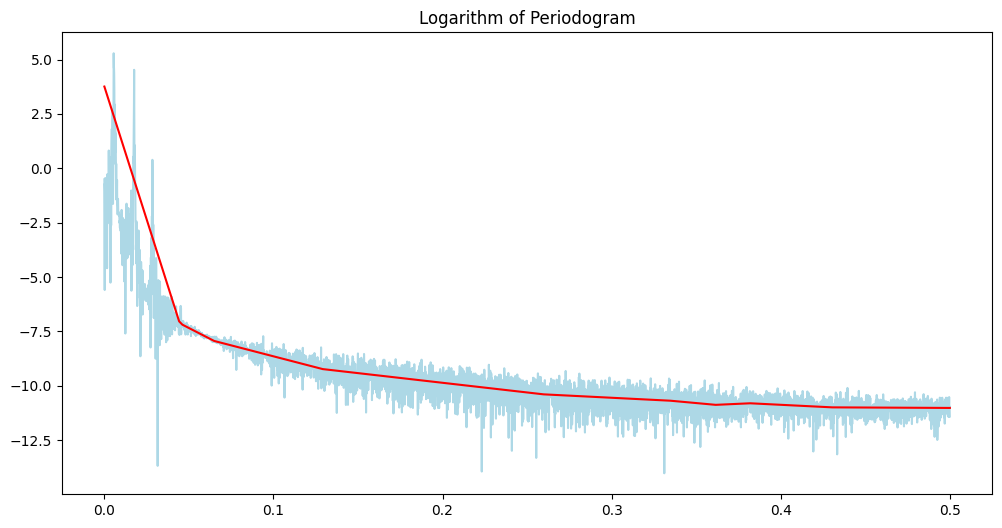

In [39]:
#alpha_est = md_PiecewiseLinear(x_torch).detach().numpy() + np.log(np.std(pgram))
alpha_est = md_PiecewiseLinear(x_torch).detach().numpy()
plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram), label = 'Log Periodogram', color = 'lightblue')
plt.plot(freqs, alpha_est, color = 'red', label = 'PyTorch Estimate')
plt.title('Logarithm of Periodogram')
plt.show()

In [40]:
import cvxpy as cp
import mosek

def spectrum_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) 
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    #problem.solve()
    problem.solve(solver = cp.MOSEK)
    return alpha.value, freq

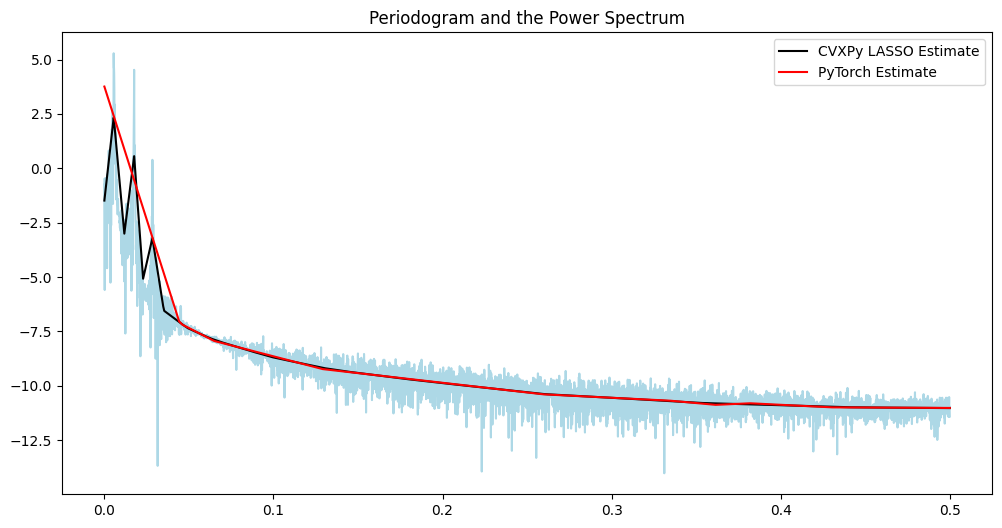

In [41]:
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 1000)
power_lasso = (2/n) * (np.exp(2 * alpha_opt_lasso))

plt.figure(figsize = (12, 6))
plt.plot(freq, np.log(pgram), color = 'lightblue')
plt.title('Periodogram and the Power Spectrum')
plt.plot(freq, np.log(power_lasso), color = 'black', label = "CVXPy LASSO Estimate")
plt.plot(freqs, alpha_est, color = 'red', label = 'PyTorch Estimate')
plt.legend()
plt.show()

The PyTorch is not able to figure out the three main peaks in the log power spectrum. This is probably because of the poor quality of the initialization. Note that the main peaks are all near the initial frequencies so that is where the knots need to be. If we find the peaks and troughs from our spectrum estimate from Lecture 15, and then initialize the PyTorch algorithm using knots near the peaks-troughs, then it will work better.  

In [42]:
from scipy.signal import find_peaks
# Find peaks
peaks, _ = find_peaks(np.log(power_lasso))
#find troughs
troughs, _ = find_peaks(-np.log(power_lasso))
print(peaks)
print(troughs)

[ 55 176 284]
[118 229]


In [43]:
k = 8 # this is the number of knots
#quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
x = np.arange(1, m+1)
x_scaled = (x - np.mean(x))/(np.std(x))
#knots_init = np.quantile(x_scaled, quantile_levels)

knots_init = (np.array([50, 120, 175, 230, 285, 340, 400, 500]) - np.mean(x))/(np.std(x)) 
# these knots are chosen to be roughly near the peaks and troughs

X = np.column_stack([np.ones(m), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float))*(x_scaled-knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(np.log(pgram), X).fit()

#print(md_init.summary())
#print(md_init.params)
beta_init = md_init.params
print(knots_init)
print(beta_init)

[-1.69774938 -1.64924225 -1.61112951 -1.57301677 -1.53490403 -1.49679129
 -1.45521375 -1.38591786]
[ 207.99767796  121.68086542 -237.90477858  200.25534348 -231.28621121
  208.44914151 -136.58094635   94.09095751  -50.99202009   31.30034846]


In [44]:
#y_torch = torch.tensor(pgram/np.std(pgram), dtype = torch.float32).unsqueeze(1)
y_torch = torch.tensor(pgram, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_scaled, dtype = torch.float32).unsqueeze(1)

md_PiecewiseLinear = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
optimizer = optim.Adam(md_PiecewiseLinear.parameters(), lr = 0.001) 

for epoch in range(20000): 
    optimizer.zero_grad()

    y_pred = md_PiecewiseLinear(x_torch)
    #loss = loss_fn(y_pred, y_torch)
    loss = torch.sum( y_pred + y_torch * torch.exp(- y_pred) )

    loss.backward() # calulates gradients

    optimizer.step() # updates parameters using gradients

    if epoch % 1000 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
# Run this code a few times to be sure of convergence. 

Epoch 0, Loss: -41205.1836
Epoch 1000, Loss: -41896.0898
Epoch 2000, Loss: -41904.6094
Epoch 3000, Loss: -41907.7344
Epoch 4000, Loss: -41907.7227
Epoch 5000, Loss: -41908.2969
Epoch 6000, Loss: -41906.9531
Epoch 7000, Loss: -41904.2344
Epoch 8000, Loss: -41908.1953
Epoch 9000, Loss: -41908.4688
Epoch 10000, Loss: -41907.9727
Epoch 11000, Loss: -41908.5391
Epoch 12000, Loss: -41908.3516
Epoch 13000, Loss: -41897.2539
Epoch 14000, Loss: -41908.6953
Epoch 15000, Loss: -41908.5977
Epoch 16000, Loss: -41908.5781
Epoch 17000, Loss: -41908.1875
Epoch 18000, Loss: -41907.3008
Epoch 19000, Loss: -41906.0352


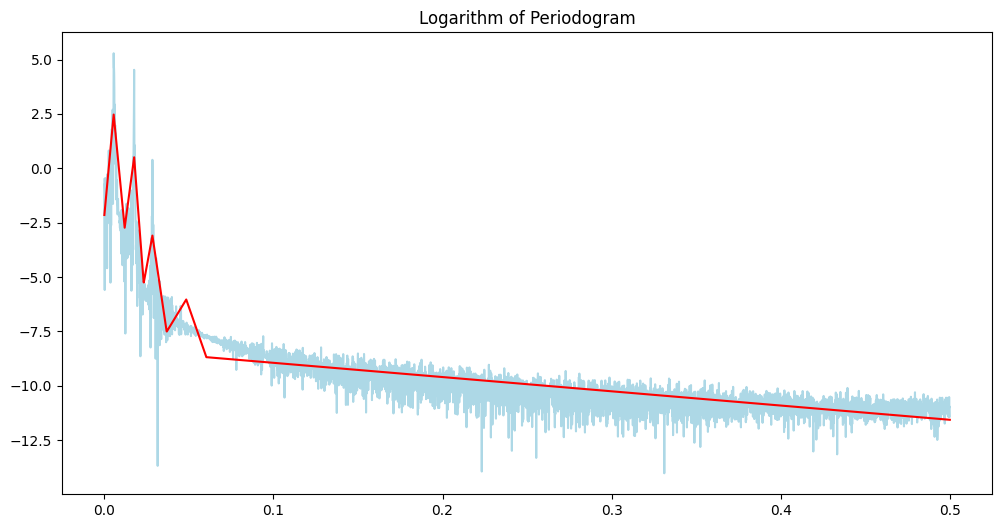

In [45]:
#alpha_est = md_PiecewiseLinear(x_torch).detach().numpy() + np.log(np.std(pgram))
alpha_est = md_PiecewiseLinear(x_torch).detach().numpy()

plt.figure(figsize = (12, 6))
plt.plot(freqs, np.log(pgram), label = 'Log Periodogram', color = 'lightblue')
plt.plot(freqs, alpha_est, color = 'red', label = 'PyTorch Estimate')
plt.title('Logarithm of Periodogram')
plt.show()

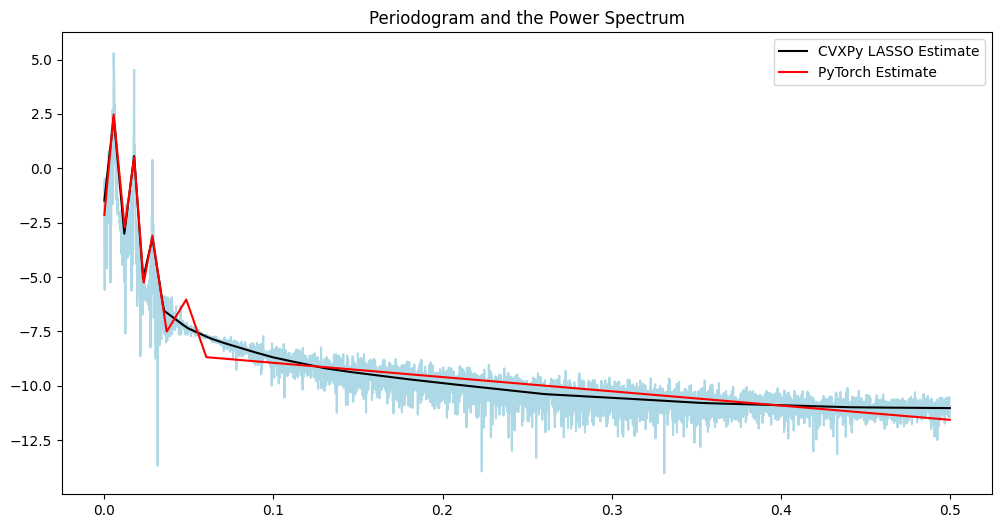

In [46]:
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 1000)
power_lasso = (2/n)*(np.exp(2*alpha_opt_lasso))

plt.figure(figsize = (12, 6))
plt.plot(freq, np.log(pgram), color = 'lightblue')
plt.title('Periodogram and the Power Spectrum')
plt.plot(freq, np.log(power_lasso), color = 'black', label = "CVXPy LASSO Estimate")
plt.plot(freqs, alpha_est, color = 'red', label = 'PyTorch Estimate')
plt.legend()
plt.show()

Now the two estimates are much closer to each other. This shows how tricky some optimization functions are. They depend sensitively on the initialization. Our estimate from Lectures 14-15 were based on convex optimization problems however which are more stable.  